In [1]:
from tensorflow import keras
import os
import numpy as np
import sys
import random
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [2]:
# Quand je regardes les donnees (images d'entrainement et target ), on ne peut que faire une segmentation semantique

im_width = 128
im_height = 128
im_channel = 3

# dataset --> 2018 Data Science Bowl: Find the nuclei in divergent images to advance medical discovery

TRAIN_PATH = "stage1_train/"
TEST_PATH = "stage1_test/"

train_ids = next(os.walk(TRAIN_PATH))[1] # ceci pour avoir la liste des sous dossiers contenu dans le repertoire parent train_path
test_ids = next(os.walk(TEST_PATH))[1]

X_train = np.zeros((len(train_ids), im_height, im_width, im_channel), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool)
print("Resizing training images and masks")

# train_images
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:im_channel]
    img = resize(img, (im_height,im_width), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((im_height, im_width, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (im_height, im_width), mode='constant',
        preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# test_images
X_test = np.zeros((len(test_ids), im_height, im_width, im_channel), dtype=np.uint8)
sizes_test = []
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:im_channel]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (im_height, im_width), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

<ipython-input-2-3b5caf91de7a>:25: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool)


Resizing training images and masks


  0%|          | 0/670 [00:00<?, ?it/s]<ipython-input-2-3b5caf91de7a>:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((im_height, im_width, 1), dtype=np.bool)
100%|██████████| 65/65 [00:05<00:00, 12.93it/s]

Done!


X_train: (670, 128, 128, 3)
Y_train: (670, 128, 128, 1)


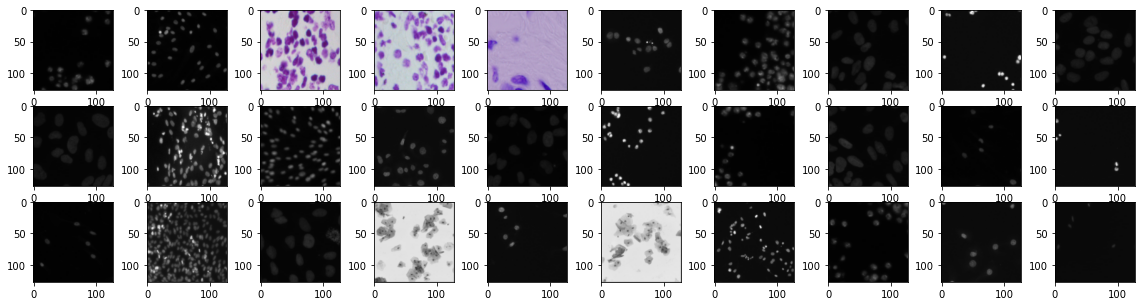

In [17]:
print("X_train:",X_train.shape)
print("Y_train:",Y_train.shape)
plt.figure(figsize=(20,5))
for i in range(30):
    plt.subplot(3,10,i+1)
    plt.imshow(X_train[i])
plt.show()

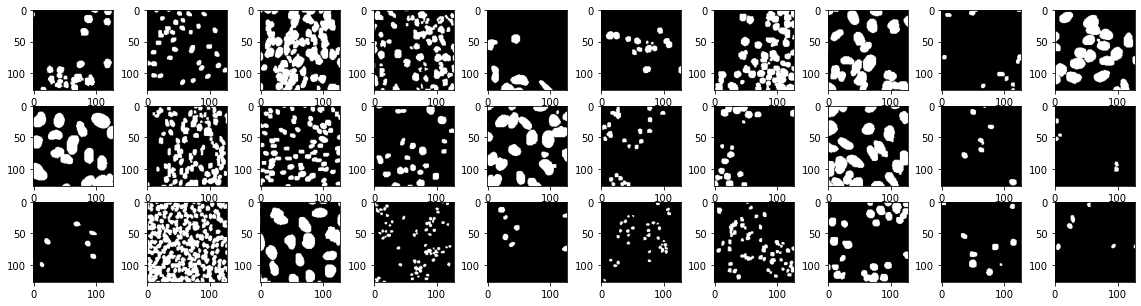

In [20]:
plt.figure(figsize=(20,5))
for i in range(30):
    plt.subplot(3,10,i+1)
    plt.imshow(Y_train[i], cmap='gray')
plt.show()

In [9]:
# Architecture du model
inputs = keras.layers.Input((im_width,im_height,im_channel))
inputs_norm = keras.layers.Lambda(lambda x: x/255)(inputs) # Normalise les pixels de l'image d'entree

# Extraction de caracteristiques et traitements de sous-echantillonnage (downscalling)
c1 = keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs_norm)
c1 = keras.layers.Dropout(0.1)(c1)
c1 = keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = keras.layers.MaxPooling2D((2,2))(c1)

c2 = keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = keras.layers.Dropout(0.1)(c2)
c2 = keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = keras.layers.MaxPooling2D((2,2))(c2)

c3 = keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = keras.layers.Dropout(0.1)(c3)
c3 = keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = keras.layers.MaxPooling2D((2,2))(c3)

c4 = keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = keras.layers.Dropout(0.2)(c4)
c4 = keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = keras.layers.MaxPooling2D((2,2))(c4)

c5 = keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = keras.layers.Dropout(0.2)(c5)
c5 = keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# Convolution inverse ou transpose convolution et traitements de surechantillonnage (upscalling)
v6 = keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
v6 = keras.layers.concatenate([v6, c4])
c6 = keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(v6)
c6 = keras.layers.Dropout(0.2)(c6)
c6 = keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

v7 = keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
v7 = keras.layers.concatenate([v7, c3])
c7 = keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(v7)
c7 = keras.layers.Dropout(0.2)(c7)
c7 = keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

v8 = keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c7)
v8 = keras.layers.concatenate([v8, c2])
c8 = keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(v8)
c8 = keras.layers.Dropout(0.1)(c8)
c8 = keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

v9 = keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c8)
v9 = keras.layers.concatenate([v9, c1], axis=3)
c9 = keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(v9)
c9 = keras.layers.Dropout(0.1)(c9)
c9 = keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = keras.layers.Conv2D(1, (1,1), activation='sigmoid')(c9)

model = keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
_______________________________________________________________________________________

In [11]:
# Entrainement du model
# Modelcheckpoint

checkpointer = keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
    keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
    keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

Epoch 1/25
 1/38 [..............................] - ETA: 0s - loss: 0.7169 - accuracy: 0.2358WARNING:tensorflow:From C:\Users\Armand Forent\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
38/38 [==============================] - 186s 5s/step - loss: 0.5974 - accuracy: 0.7816 - val_loss: 0.4240 - val_accuracy: 0.8162
Epoch 2/25
38/38 [==============================] - 162s 4s/step - loss: 0.3610 - accuracy: 0.7977 - val_loss: 0.2435 - val_accuracy: 0.8169
Epoch 3/25
38/38 [==============================] - 152s 4s/step - loss: 0.2335 - accuracy: 0.8791 - val_loss: 0.1681 - val_accuracy: 0.9296
Epoch 4/25
38/38 [==============================] - 149s 4s/step - loss: 0.1535 - accuracy: 0.9413 - val_loss: 0.1311 - val_accuracy: 0.9477
Epoch 5/25
38/38 [==============================] - 150s 4s/step

In [21]:
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

print("preds_train:", preds_train.shape)
print("preds_train_t:", preds_train_t.shape)


3/3 [==============================] - 2s 682ms/step
preds_train: (603, 128, 128, 1)
preds_train_t: (603, 128, 128, 1)


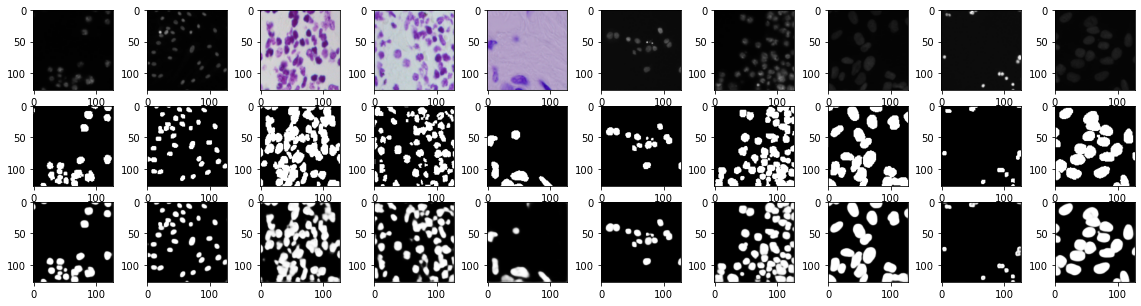

In [23]:
# Par abus j'evalue le modele sur les donnees de train (ce qui n'est pas recommande)
plt.figure(figsize=(20,5))
for i in range(10):
    j = i+10
    k = i+20
    plt.subplot(3,10,i+1)
    plt.imshow(X_train[i])
    plt.subplot(3,10,j+1)
    plt.imshow(Y_train[i], cmap='gray')
    plt.subplot(3,10,k+1)
    plt.imshow(preds_train[i], cmap='gray')
plt.show()

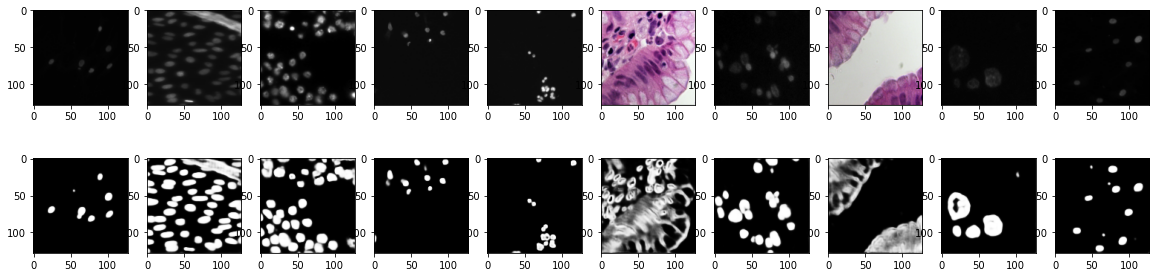

In [28]:
# prediction sur les donnees de test
plt.figure(figsize=(20,5))
for i in range(10):
    j = i+10
    plt.subplot(2,10,i+1)
    plt.imshow(X_test[i])
    plt.subplot(2,10,j+1)
    plt.imshow(preds_test[i], cmap='gray')
plt.show()

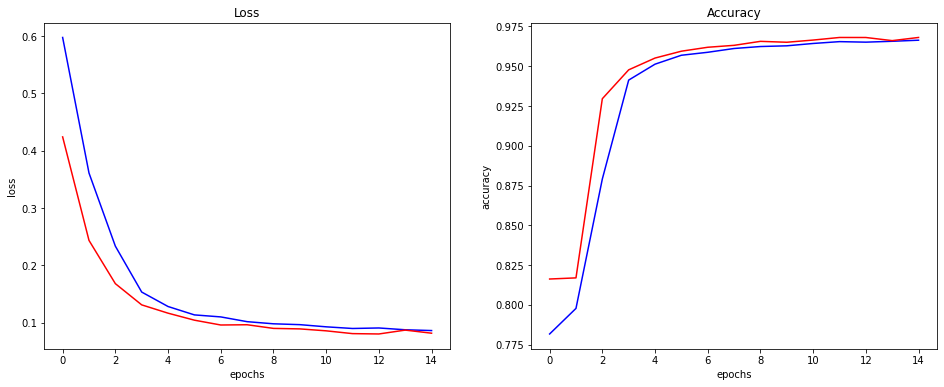

In [25]:
# Visualisation des courbes d'apprentissages
train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.title("Loss")
plt.plot(train_loss, c='b',label='train_loss')
plt.plot(val_loss, c='r', label='val_loss')
plt.xlabel('epochs')
plt.ylabel("loss")
plt.legend()

plt.subplot(1,2,2)
plt.title("Accuracy")
plt.plot(train_acc, c='b',label='train_acc')
plt.plot(val_acc, c='r', label='val_acc')
plt.xlabel('epochs')
plt.ylabel("accuracy")
plt.legend()
plt.show()

<ipython-input-63-e6b57a0bf4f4>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3,10,i+1)
<ipython-input-63-e6b57a0bf4f4>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3,10,j+1)


ValueError: num must be 1 <= num <= 30, not 31

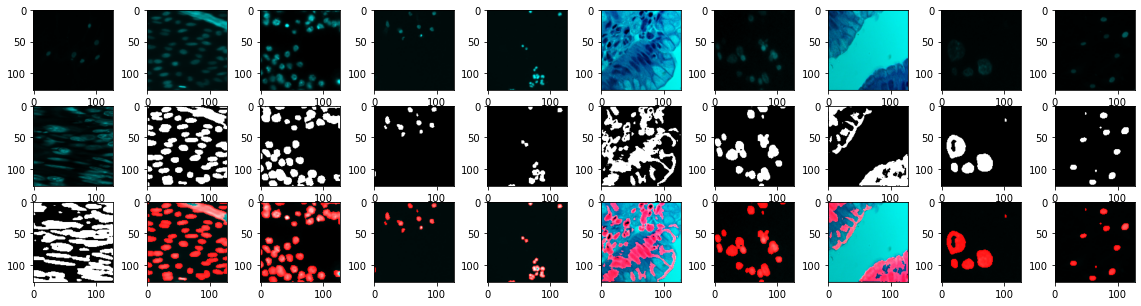

In [63]:
plt.figure(figsize=(20,5))
for i in range(30):
    j = i + 10
    k = i + 20
    image = X_test[i]
    plt.subplot(3,10,i+1)
    plt.imshow(image)
    mask = preds_test_t[i]*255
    mask = mask.reshape((mask.shape[0],mask.shape[1]))
    plt.subplot(3,10,j+1)
    plt.imshow(mask, cmap='gray')
    image[:,:,0] = mask
    plt.subplot(3,10,k+1)
    plt.imshow(image)
plt.show()

(128, 128, 1)
[0 1 0 0 0]
(128, 128, 5)
